# Parameterizations

In this notebook, we'll review tools for defining, running, and comparing subgrid parameterizations.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 10)
import pyqg
import pyqg.diagnostic_tools
import matplotlib.pyplot as plt
%matplotlib inline

## Run baseline high- and low-resolution models

To illustrate the effect of parameterizations, we'll run two baseline models:

* a low-resolution model without parameterizations at `nx=64` resolution (where $\Delta x$ is larger than the deformation radius $r_d$, preventing the model from fully resolving eddies),

* a high-resolution model at `nx=256` resolution (where $\Delta x$ is ~4x finer than the deformation radius, so eddies can be almost fully resolved).

In [2]:
%%time
year = 24*60*60*360.
base_kwargs = dict(dt=3600., tmax=5*year, tavestart=2.5*year, twrite=25000)

low_res = pyqg.QGModel(nx=64, **base_kwargs)
low_res.run()

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 4.14e-04, CFL: 0.042


CPU times: user 14.3 s, sys: 23.6 s, total: 38 s
Wall time: 10.8 s


In [3]:
%%time
high_res = pyqg.QGModel(nx=256, **base_kwargs)
high_res.run()

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 4.62e-04, CFL: 0.217


CPU times: user 3min 47s, sys: 5min 43s, total: 9min 30s
Wall time: 2min 55s


## Run Smagorinsky and backscatter parameterizations

Now we'll run two types of parameterization: one from [Smagorinsky 1963](https://doi.org/10.1175/1520-0493(1963)091%3C0099:GCEWTP%3E2.3.CO;2) which models an effective eddy viscosity from subgrid stress, and one adapted from [Jansen and Held 2014](https://doi.org/10.1016/j.ocemod.2014.06.002) and [Jansen et al. 2015](https://doi.org/10.1016/j.ocemod.2015.05.007), which reinjects a fraction of the energy dissipated by Smagorinsky back into larger scales:

In [4]:
def run_parameterized_model(p):
    model = pyqg.QGModel(nx=64, parameterization=p, **base_kwargs)
    model.run()
    return model

In [5]:
%%time
smagorinsky = run_parameterized_model(
    pyqg.parameterizations.Smagorinsky(constant=0.08))

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 3.37e-04, CFL: 0.043


CPU times: user 39.3 s, sys: 1min, total: 1min 39s
Wall time: 30.3 s


In [8]:
%%time
backscatter = run_parameterized_model(
    pyqg.parameterizations.BackscatterBiharmonic(smag_constant=0.08, back_constant=1.1))

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 5.35e-04, CFL: 0.048


CPU times: user 35.9 s, sys: 57.8 s, total: 1min 33s
Wall time: 27.5 s


Note how these are slightly slower than the baseline low-resolution model, but much faster than the high-resolution model.

See the parameterizations API section and code for examples of how these parameterizations are defined!

## Compute similarity metrics between parameterized and high-resolution simulations

To assist with evaluating the effects of parameterizations, we include helpers for computing similarity metrics between model diagnostics. Similarity metrics quantify the percentage closer a diagnostic is to high resolution than low resolution; values greater than 0 indicate improvement over low resolution (with 1 being the maximum), while values below 0 indicate worsening. We can compute these for all diagnostics for all four simulations:

In [9]:
def label_for(sim):
    return f"nx={sim.nx}, {sim.parameterization or 'unparameterized'}"

sims = [high_res, backscatter, low_res, smagorinsky]

pd.DataFrame.from_dict([
    dict(Simulation=label_for(sim),
        **pyqg.diagnostic_tools.diagnostic_similarities(sim, high_res, low_res)) 
    for sim in sims])

,Simulation,Ensspec1,Ensspec2,KEspec1,KEspec2,...,ENSfrictionspec,APEgenspec,APEflux,KEflux,APEgen
0,"nx=256, unparameterized",1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000
1,"nx=64, BackscatterBiharmonic(Cs=0.08, Cb=1.1)",0.617871,0.595677,0.719966,0.776835,...,0.444769,0.222930,0.571082,0.448418,0.015557
2,"nx=64, unparameterized",0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000
3,"nx=64, Smagorinsky(Cs=0.08)",-0.049632,0.476905,-0.242329,-0.269631,...,-0.161524,0.069705,-0.171567,-0.296460,0.206204


Note that the high-resolution and low-resolution models themselves have similarity scores of 1 and 0 by definition. In this case, the backscatter parameterization is consistently closer to high-resolution than low-resolution, while the Smagorinsky is consistently further.

Let's plot some of the actual curves underlying these metrics to get a better sense:

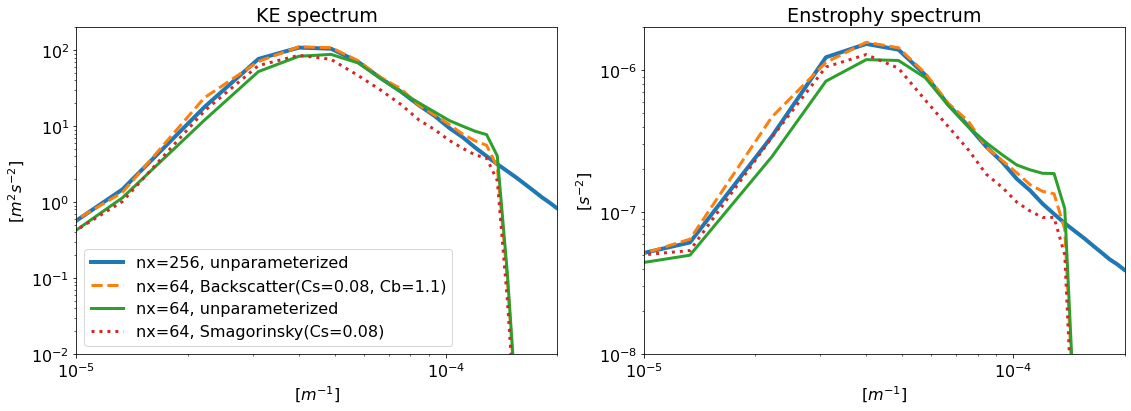

In [19]:
def plot_kwargs_for(sim):
    kw = dict(label=label_for(sim).replace('Biharmonic',''))
    kw['ls'] = (':' if sim.uv_parameterization else ('--' if sim.q_parameterization else '-'))
    kw['lw'] = (4 if sim.nx==256 else 3)
    return kw

plt.figure(figsize=(16,6))
plt.rcParams.update({'font.size': 16})

plt.subplot(121, title="KE spectrum")
for sim in sims:
    plt.loglog(
        *pyqg.diagnostic_tools.calc_ispec(sim, sim.get_diagnostic('KEspec').sum(0)),
        **plot_kwargs_for(sim))
plt.ylabel("[$m^2 s^{-2}$]")
plt.xlabel("[$m^{-1}$]")
plt.ylim(1e-2,2e2)
plt.xlim(1e-5, 2e-4)
plt.legend(loc='lower left')

plt.subplot(122, title="Enstrophy spectrum")
for sim in sims:
    plt.loglog(
        *pyqg.diagnostic_tools.calc_ispec(sim, sim.get_diagnostic('Ensspec').sum(0)),
        **plot_kwargs_for(sim))
plt.ylabel("[$s^{-2}$]")
plt.xlabel("[$m^{-1}$]")
plt.ylim(1e-8,2e-6)
plt.xlim(1e-5, 2e-4)
plt.tight_layout()

The backscatter model, though low-resolution, has energy and enstrophy spectra that more closely resemble those of the high-resolution model.